# IEEE Fraud Detection Kaggle Competition
## LightGBM TransactionDT feature engineering

In [1]:
%%bash

ls -l

echo ''

cd ../data

ls -l

echo ''

cd ../output

ls -l

total 17256
-rw-r--r--  1 cchadha2  749149485  1976809 Aug  9 10:16 EDA.ipynb
-rw-r--r--  1 cchadha2  749149485  1661687 Jul 29 22:42 IDs-EDA.ipynb
-rw-r--r--  1 cchadha2  749149485   222386 Aug  8 22:25 adverserial_validation.ipynb
-rw-r--r--  1 cchadha2  749149485   239908 Aug 12 23:40 lgb_<2_importance_removed_card1_count_encoded.ipynb
-rw-r--r--  1 cchadha2  749149485   614375 Aug 12 23:36 lgb_TransactionDay.ipynb
-rw-r--r--  1 cchadha2  749149485   667100 Aug 12 23:20 lgb_TransactionDay_and_TransactionHour.ipynb
-rw-r--r--  1 cchadha2  749149485   588984 Aug 12 23:58 lgb_TransactionHour.ipynb
-rw-r--r--  1 cchadha2  749149485   588984 Aug 12 23:59 lgb_remove_D9.ipynb
-rw-r--r--  1 cchadha2  749149485   237097 Aug  7 15:28 lightgbm_baseline.ipynb
-rw-r--r--  1 cchadha2  749149485   345397 Aug 12 23:27 lightgbm_card1_count_encoded.ipynb
-rw-r--r--  1 cchadha2  749149485   230960 Aug  8 22:25 lightgbm_card1_count_encoded_20kval.ipynb
-rw-r--r--  1 cchadha2  749149485   867988 Jul 30 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

/Users/cchadha2/anaconda3/envs/lgbm/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [3]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)

num_folds = 5
SEED = 5000

# Load and prepare data

In [4]:
train = pd.read_csv('../output/train_card1_count.csv')
test = pd.read_csv('../output/test_card1_count.csv')
sub_df = pd.read_csv('../data/sample_submission.csv.zip')

In [5]:
val_indices = np.load('../output/val_indices.npy')

In [6]:
train.head(10)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,card1_count
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.

In [7]:
print(train.shape)

(590540, 435)


In [8]:
print(test.shape)

(506691, 434)


In [9]:
# Lightgbm parameters from https://www.kaggle.com/vincentlugat/ieee-lgb-bayesian-opt
params = {
        'bagging_fraction': 0.8999999999997461,
        'feature_fraction': 0.8999999999999121,
        'max_depth': int(50.0),
        'min_child_weight': 0.0029805017044362268,
        'min_data_in_leaf': int(20.0),
        'num_leaves': int(381.85354295079446),
        'reg_alpha': 1.0,
        'reg_lambda': 2.0,
        'objective': 'binary',
        'save_binary': True,
        'seed': SEED,
        'feature_fraction_seed': SEED,
        'bagging_seed': SEED,
        'drop_seed': SEED,
        'data_random_seed': SEED,
        'boosting_type': 'gbdt',
        'verbose': 1,
        'is_unbalance': False,
        'boost_from_average': True,
        'metric':'auc'
    }

early_rounds = 50
num_iterations = 200

In [10]:
categorical_features=['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
                      'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'M1',
                      'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9',
                      'DeviceType', 'DeviceInfo', 'id_12', 'id_13', 'id_14', 'id_15',
                      'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22',
                      'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29',
                      'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36',
                      'id_37', 'id_38']

In [11]:
for feature in categorical_features:
    train[feature] = train[feature].astype('category')
    test[feature] = test[feature].astype('category')

# Splitting into train, val, and test

In [12]:
# Split train into features and target
X = train.drop(['isFraud', 'TransactionDT', 'TransactionID', 'D9'], axis=1)
y = train['isFraud']

In [13]:
val_indices

array([  5949,  10454,  12753, ..., 590520, 590526, 590529])

In [14]:
X_val = X.iloc[val_indices, :]
y_val = y.iloc[val_indices]

In [15]:
X_train = X.drop(val_indices)
y_train = y.drop(val_indices)

In [16]:
X_train.shape

(583369, 431)

In [17]:
X_val.shape

(7171, 431)

In [18]:
X_test = test.drop(['TransactionDT', 'TransactionID', 'D9'], axis=1)

# Train LightGBM

In [19]:
# Create arrays for oof predictions and sub predictions
val_preds = np.zeros(len(X_val))
sub_preds = np.zeros(len(sub_df))

In [20]:
trn_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val)

In [21]:
clf = lgb.train(params, trn_data, num_iterations, valid_sets=[trn_data, val_data], verbose_eval=50,
                early_stopping_rounds=early_rounds)

/Users/cchadha2/anaconda3/envs/lgbm/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994883	valid_1's auc: 0.973698
[100]	training's auc: 0.99935	valid_1's auc: 0.97898
[150]	training's auc: 0.999904	valid_1's auc: 0.981135
[200]	training's auc: 0.999984	valid_1's auc: 0.981534
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999984	valid_1's auc: 0.981534


# Predict on test sets

In [22]:
sub_preds = clf.predict(X_test, num_iteration=clf.best_iteration)
val_preds = clf.predict(X_val, num_iteration=clf.best_iteration)

In [23]:
sub_preds

array([2.18602623e-05, 4.65749176e-04, 2.48386317e-05, ...,
       1.39045354e-03, 3.28413790e-04, 1.37742357e-04])

In [24]:
print('AUROC on validation set: {}'.format(roc_auc_score(y_val.values, val_preds)))

AUROC on validation set: 0.9815335328740022


# Bootstrapping

In [25]:
# Bootstrapping AUROC
n_bootstraps = 10000
bootstrapped_scores = []

np.random.seed(SEED)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = np.random.randint(0, len(val_preds) - 1, len(val_preds))
    if len(np.unique(y_val.values[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_val.values[indices], val_preds[indices])
    bootstrapped_scores.append(score)

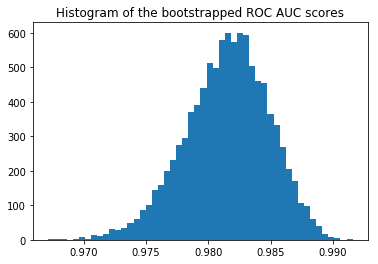

In [26]:
plt.figure()
plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

In [27]:
sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 90% confidence interval
# You can change the bounds percentiles to 0.025 and 0.975 to get
# a 95% confidence interval instead.
confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

Confidence interval for the score: [0.976 - 0.987]


In [28]:
sorted_scores.mean()

0.9815075261387032

In [29]:
sorted_scores.std()

0.0033704618639726867

# Save submission predictions

In [30]:
sub_df['isFraud'] = sub_preds
sub_df.to_csv('../submissions/submission_remove_D9.csv', index=False)

# Feature importances

In [31]:
# Concatenate fold importances into feature importance dataframe
feature_importance_df = pd.DataFrame()
feature_importance_df["feature"] = X_train.columns.tolist()
feature_importance_df["importance"] = clf.feature_importance()

In [32]:
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

In [33]:
feature_importance_df.head()

,feature,importance
2,card1,7881
0,TransactionAmt,5767
8,addr1,3682
430,card1_count,2903
10,dist1,2760


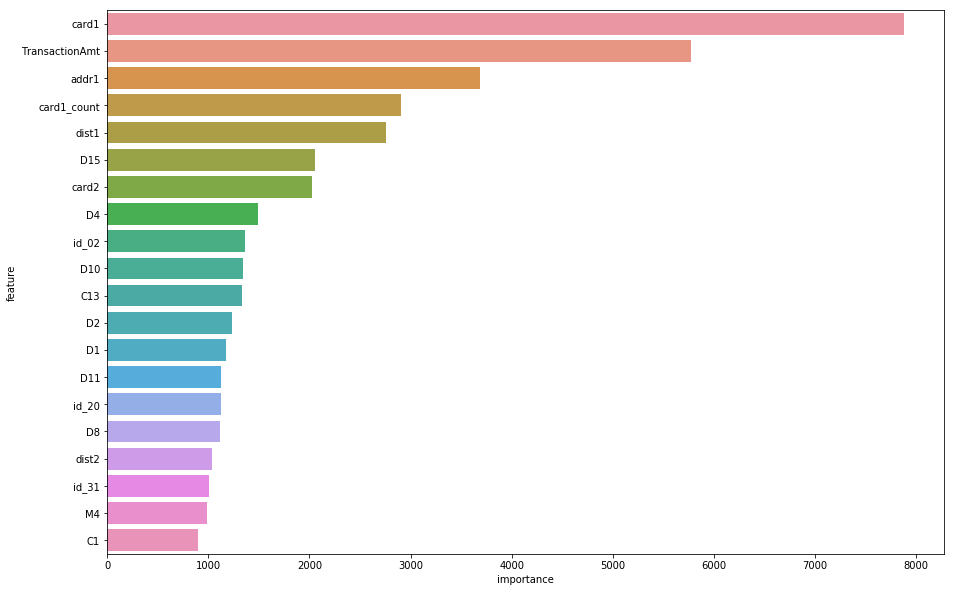

In [34]:
plt.figure(figsize=(15,10))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20))